In [1]:
import pandas as pd
import geopandas as gpd
import geodatasets
import h3pandas
import rasterstats
import matplotlib.pyplot as plt
import rasterio
from rasterio.vrt import WarpedVRT
from rasterio import transform
from rasterio.plot import show
import rioxarray
import xarray
import tszip
import numpy as np
import sys
sys.path.append("/Users/jameskitchens/Documents/GitHub/terracotta")
import terracotta as tct
import importlib
importlib.reload(tct)
from os import mkdir

In [2]:
gdf = gpd.read_file(geodatasets.get_url("naturalearth land"))
gdf = gdf.loc[112:112]
resolution = 2
gdf_h3 = gdf.h3.polyfill_resample(resolution)
gdf_h3 = gdf_h3.reset_index()
gdf_h3["deme"] = gdf_h3.index
gdf_h3.explore()

In [3]:
gdf_h3 = gdf_h3.drop([467, 845, 875, 175, 388, 439, 806, 625]) #drop these because of antimeridian
gdf_h3.explore()

In [4]:
import matplotlib as mpl

oranges = mpl.colormaps['Oranges'].resampled(4)

print(oranges(range(4))*255)

[[255.         245.         235.         255.        ]
 [253.         185.33333333 125.33333333 255.        ]
 [233.          94.          13.         255.        ]
 [127.          39.           4.         255.        ]]


/opt/anaconda3/envs/terracotta/lib/python3.12/site-packages/rasterstats/io.py:335: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(


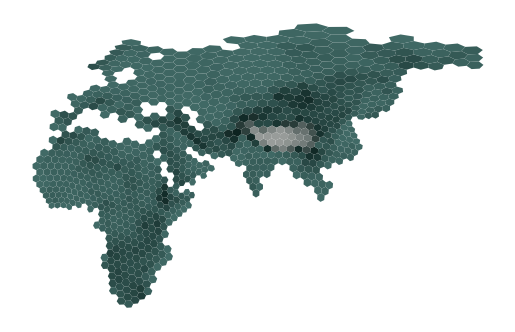

In [5]:
from matplotlib.colors import LinearSegmentedColormap

xds = xarray.open_dataset("datasets/gis/elevation/ETOPO2v2c_f4.nc")
xds["z"].rio.to_raster("datasets/gis/elevation/world_elevation.tif")

with rasterio.open("datasets/gis/elevation/world_elevation.tif") as src_dst:
    with WarpedVRT(
        src_dst,
        src_crs=src_dst.gcps[1],
        src_transform=transform.from_gcps(src_dst.gcps[0]),
    ) as vrt:
        mean_elev = []
        for stat in rasterstats.zonal_stats(
            gdf_h3,
            vrt.read(1),
            affine=vrt.transform,
            stats="mean"
        ):
            mean_elev.append(stat["mean"])
        gdf_h3["mean_elev"] = mean_elev

colors = ["#416A66", "#0C2320", "#989C9A"]
cmap1 = LinearSegmentedColormap.from_list("mycmap", colors)

gdf_h3.plot(column="mean_elev", cmap=cmap1, vmin=0)
plt.axis("off")
#plt.savefig("figures/elevation_by_deme.svg")
plt.show()

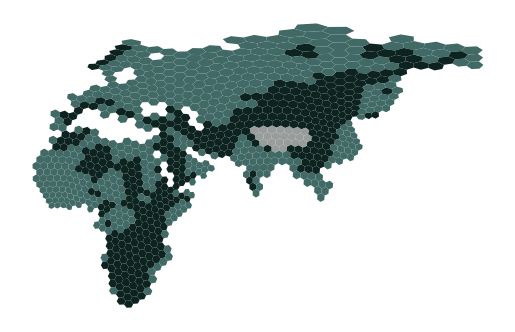

In [6]:
bins = [-10000, 500, 4000, 10000]
gdf_h3["binned_elev"] = np.searchsorted(bins, gdf_h3["mean_elev"].values)
gdf_h3.plot(column="binned_elev", cmap=cmap1, vmin=1)
plt.axis("off")
#plt.savefig("figures/elevation_by_deme_binned_3.svg")
plt.show()

In [7]:
sample_locs = pd.read_csv("datasets/sample_locations.csv")
sample_locs = gpd.GeoDataFrame(sample_locs, geometry=gpd.GeoSeries.from_xy(sample_locs["lon"], sample_locs["lat"]), crs=4326)
sample_locs_with_region = gpd.sjoin(sample_locs, gdf_h3, how="inner", predicate="within").loc[:, ["id", "deme"]]
regions_with_samples = sample_locs_with_region["deme"].unique()

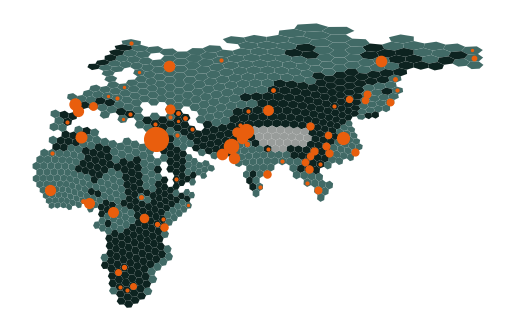

In [8]:
deme_sample_counts = sample_locs_with_region.value_counts("deme").reset_index()

base = gdf_h3.plot(column="binned_elev", cmap=cmap1, vmin=1)
for i,row in gdf_h3.iterrows():
    count = sum(deme_sample_counts.loc[deme_sample_counts["deme"]==row["deme"], "count"])
    if count > 0:
        center = row["geometry"].centroid
        plt.scatter(center.x, center.y, s=count, color="#E95E0D")
plt.axis("off")
#plt.savefig("figures/elevation_by_deme_binned_3_samples.svg")
plt.show()

In [9]:
gdf_h3["geometry"] = gdf_h3.buffer(0.1)
#with open("datasets/evolution_take_7/demes.tsv", "w") as outfile:
#    outfile.write("id\txcoord\tycoord\ttype\tneighbours\n")
#    for i, row in gdf_h3.iterrows():
#        neighbors = np.array(gdf_h3[gdf_h3.geometry.touches(row['geometry'])].deme)
#        #overlapping neighbors use if discrepances found with touches
#        overlap = np.array(gdf_h3[gdf_h3.geometry.overlaps(row['geometry'])].deme)
#        neighbors = [str(d) for d in np.sort(np.union1d(neighbors, overlap))]
#        center = row["geometry"].centroid
#        outfile.write(f"{row["deme"]}\t{center.x}\t{center.y}\t{row["binned_elev"]-1}\t{",".join(neighbors)}\n")

/var/folders/q8/b10jdgls4xvcv3wz767kf6f80000gn/T/ipykernel_18584/3353827143.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_h3["geometry"] = gdf_h3.buffer(0.1)


In [18]:
ts = tszip.load("datasets/hgdp_tgp_sgdp_high_cov_ancients_chr17_p.dated.trees.tsz")
ts, map_nodes = ts.simplify(samples=sample_locs_with_region["id"], map_nodes=True)

print(ts.at_index(36750))

#for i, tree in enumerate(ts.trees()):
#    if tree.span == 690:
#        print(i, tree.span)
    
#sample_locs_with_region["orig_id"] = sample_locs_with_region["id"]
#sample_locs_with_region["id"] = map_nodes[sample_locs_with_region["id"]]
#sample_locs_with_region.to_csv("datasets/evolution_take_7/samples.tsv", sep="\t", index=False)

╔════════════════════════════════════════════════╗
║Tree                                            ║
╠═══════════════════╤════════════════════════════╣
║Index              │                      36,750║
╟───────────────────┼────────────────────────────╢
║Interval           │19,546,431-19,547,824(1,393)║
╟───────────────────┼────────────────────────────╢
║Roots              │                           1║
╟───────────────────┼────────────────────────────╢
║Nodes              │                       2,924║
╟───────────────────┼────────────────────────────╢
║Sites              │                          29║
╟───────────────────┼────────────────────────────╢
║Mutations          │                          59║
╟───────────────────┼────────────────────────────╢
║Total Branch Length│                   1,706,783║
╚═══════════════════╧════════════════════════════╝



In [11]:
def create_trees_folder_from_ts(ts, output_path=".", gap_between_trees=1, discretize_time=False):
    #mkdir(f"{output_path}/trees")
    for i in range(0, ts.num_trees, gap_between_trees):
        tree = ts.at_index(i)
        interval = tree.interval
        single_tree_ts = ts.keep_intervals([interval], simplify=True).trim()
        print(single_tree_ts)
        #single_tree_ts.dump(f"{output_path}/trees/{i}.trees")

create_trees_folder_from_ts(
    ts=ts,
    output_path=".",
    gap_between_trees=375
)

╔═════════════════════════╗
║TreeSequence             ║
╠═══════════════╤═════════╣
║Trees          │        1║
╟───────────────┼─────────╢
║Sequence Length│   282184║
╟───────────────┼─────────╢
║Time Units     │  unknown║
╟───────────────┼─────────╢
║Sample Nodes   │     1906║
╟───────────────┼─────────╢
║Total Size     │524.8 KiB║
╚═══════════════╧═════════╝
╔═══════════╤═════╤══════════╤════════════╗
║Table      │Rows │Size      │Has Metadata║
╠═══════════╪═════╪══════════╪════════════╣
║Edges      │2,372│  74.1 KiB│          No║
╟───────────┼─────┼──────────┼────────────╢
║Individuals│  953│ 331.8 KiB│         Yes║
╟───────────┼─────┼──────────┼────────────╢
║Migrations │    0│   8 Bytes│          No║
╟───────────┼─────┼──────────┼────────────╢
║Mutations  │   52│   1.9 KiB│          No║
╟───────────┼─────┼──────────┼────────────╢
║Nodes      │2,373│  76.5 KiB│         Yes║
╟───────────┼─────┼──────────┼────────────╢
║Populations│  136│   6.7 KiB│         Yes║
╟───────────┼─────┼─

In [30]:
demes = pd.read_csv("datasets/evolution_take_7/demes.tsv", sep="\t")
samples = pd.read_csv("datasets/evolution_take_7/samples.tsv", sep="\t")
world_map = tct.WorldMap(demes, samples)

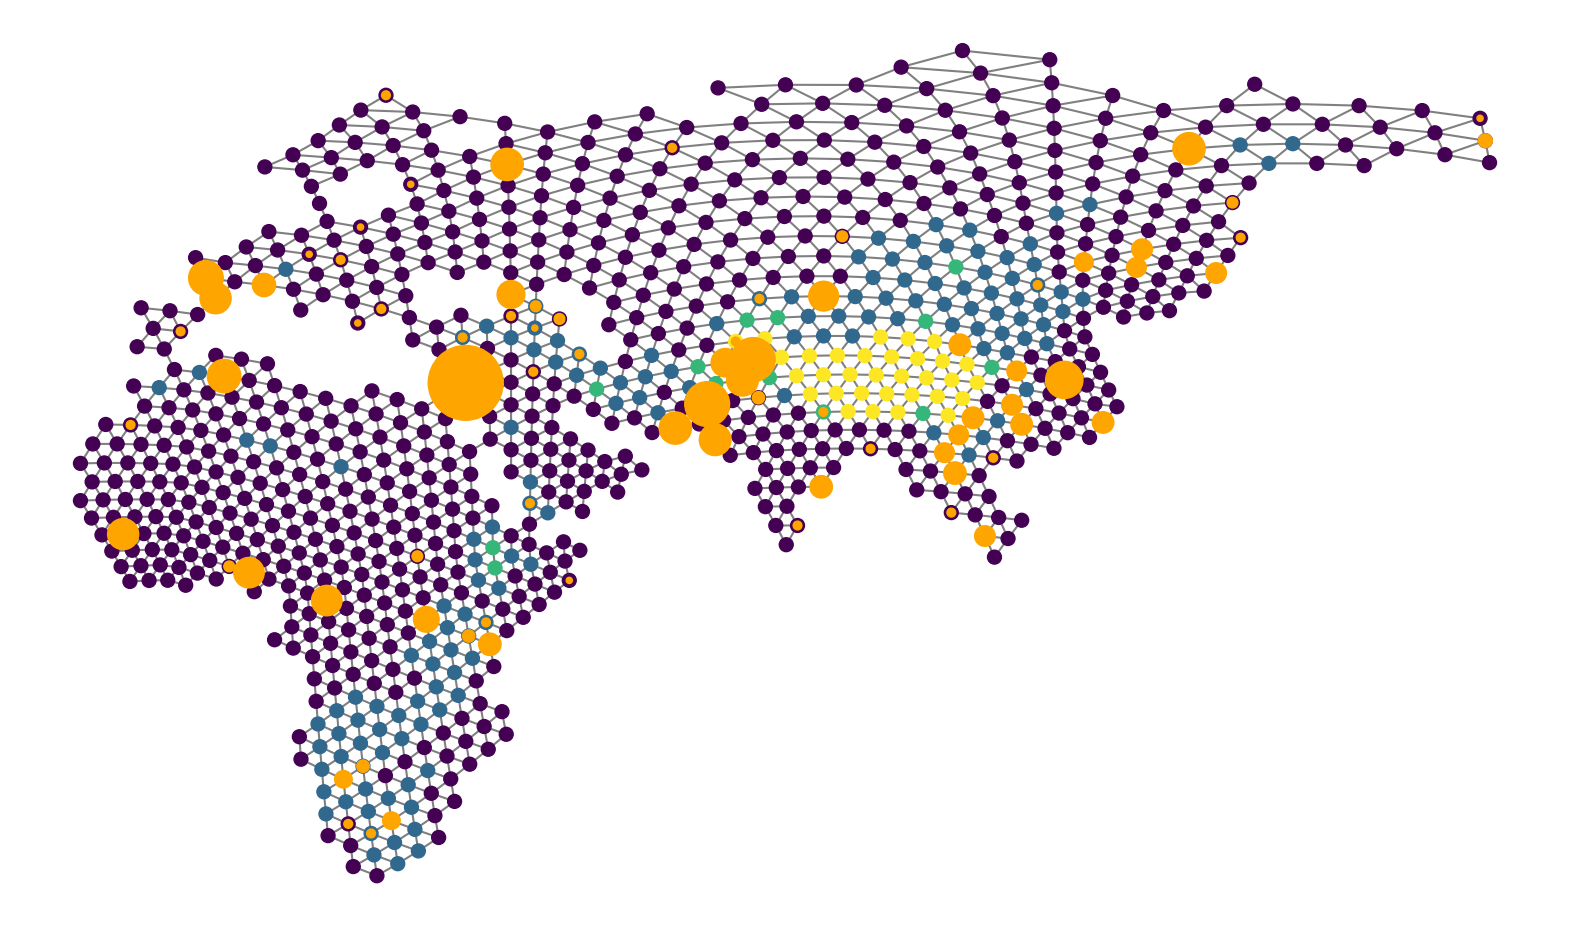

In [31]:
world_map.draw(figsize=(20,20), show_samples=True, color_demes=True, save_to="figures/world_map_evolution_take_7.svg")

In [32]:
connections = []
deme_types = range(world_map.demes["type"].max()+1)
for i,type0 in enumerate(deme_types):
    for type1 in deme_types[i:]:
        connections.append(f"{type0}-{type1}")
counts = world_map.connections["type"].value_counts().sort_index()
print(counts)
#pd.DataFrame(connections, columns=["connection"]).join(counts)

type
0    1661
1     554
2      68
3     129
Name: count, dtype: int64


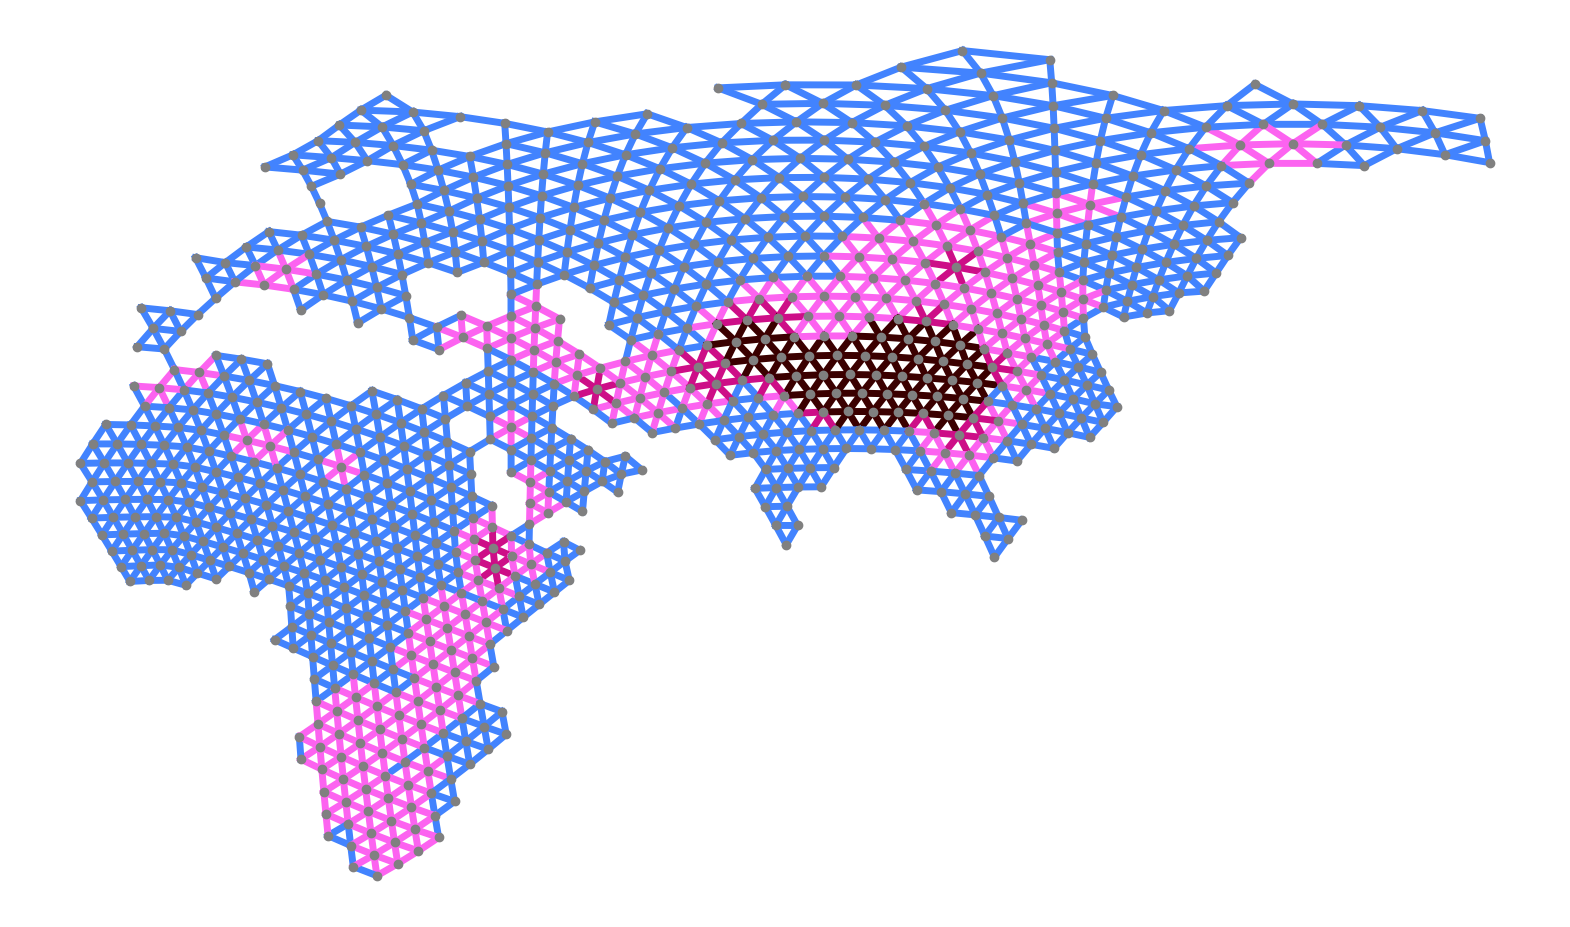

In [33]:
world_map.draw(figsize=(20,20), color_connections=True)

In [29]:
world_map.connections.type.unique()

array([1, 0, 5, 3, 2, 4])